### Including libraries

In [1]:
import numpy as np
import matplotlib.pylab as plt
import os
from scipy.integrate import odeint
%matplotlib inline

In [2]:
path = "data"
os.makedirs(path, exist_ok=True)

# Sinus Waves Dataset Generation

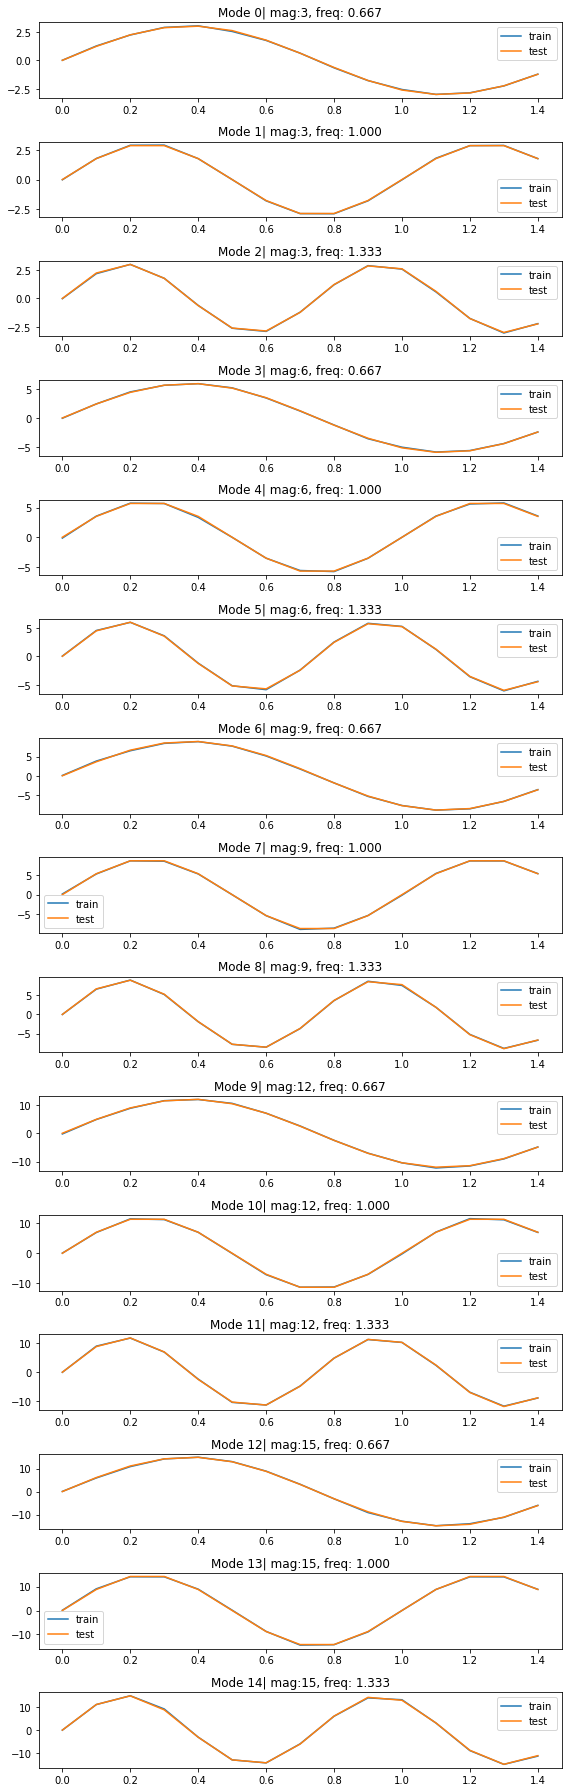

In [4]:
def generate_sinus_data(dt=0.1, path="data/"):
    os.makedirs(path, exist_ok=True)
    np.random.seed(1773)
    T = 15
    nof_sequence = 12
    nof_tasks = 5
    mode_per_task = 3
    N = nof_sequence + nof_sequence // 2
    jump = 5
    magnitutes = [3, 6, 9, 12, 15]
    frequencies = [6/9, 9/9, 12/9]

    function = lambda mag, freq, t, mode : [mag * np.sin(2*np.pi*freq*t), mag * np.sin(2*np.pi*freq*t) + np.random.normal(0, mag/100., size=t.shape)][mode=="train"]
    t = np.linspace(start=0, stop=dt*(T+jump)*nof_tasks*N, num=N*(T+jump)*nof_tasks+1)[:-1]
    modes_list = list((x, y) for x in magnitutes for y in frequencies)
    num_mods = len(modes_list)
    mode_datas_train = np.zeros((num_mods, N*(T+jump)*nof_tasks))
    mode_datas_test= np.zeros((num_mods, N*(T+jump)*nof_tasks))
    
    f, ax = plt.subplots(num_mods, 1, figsize=(8, 25)) 
    for i, (mag, freq) in enumerate(modes_list):
        mode_datas_train[i] = function(mag, freq, t, "train")
        mode_datas_test[i] = function(mag, freq, t, "test")
        ax[i].plot(t[:T], mode_datas_train[i][:T], label="train")
        ax[i].plot(t[:T], mode_datas_test[i][:T], label="test")
        ax[i].set_title(f"Mode {i}| mag:{mag}, freq: {freq:.3f}")
        ax[i].legend()
    
    plt.tight_layout()
    plt.savefig(f"{path}/sinus waves.png")
    np.random.seed(1773)
    np.random.shuffle(modes_list)
    tasks = [modes_list[i:i+mode_per_task] for i in range(0, len(modes_list), mode_per_task)]
    mode_indexes = np.zeros(num_mods, dtype=int)
    
    Xs = {"train": [], "test": []}
    Ys = {"train": [], "test": []}
    Modes = {"train": [], "test": []}
    Ns = {"train": nof_sequence, "test": nof_sequence // 2}
    mode_datas = {"train": mode_datas_train, "test": mode_datas_test}

    for key in Xs:
        n = Ns[key]

        for task_id, task in enumerate(tasks):
            for mode_num, mode in enumerate(task):
                for _ in range(n):
                    start_id = mode_indexes[modes_list.index(mode)]
                    end_id = start_id + T
                    data_ = mode_datas[key][modes_list.index(mode)][start_id:end_id]
                    tasks_ = np.ones(1) * task_id
                    modes_ = np.ones(1) * modes_list.index(mode)
                    
                    mode_indexes[modes_list.index(mode)] += T + jump
                    Xs[key].append([data_.copy()])
                    Ys[key].append([tasks_.copy()])
                    Modes[key].append([modes_.copy()])
                

    Xtr = np.expand_dims(np.concatenate(Xs["train"], axis=0), -1)
    Ytr = np.concatenate(Ys["train"], axis=1)
    Modetr = np.concatenate(Modes["train"], axis=1)
    
    np.save(f"{path}/training", Xtr)
    np.save(f"{path}/training_tasks", Ytr)
    np.save(f"{path}/training_modes", Modetr)

    Xtest = np.expand_dims(np.concatenate(Xs["test"], axis=0), -1)
    Ytest = np.concatenate(Ys["test"], axis=1)
    Modetest = np.concatenate(Modes["test"], axis=1)
    np.save(f"{path}/test", Xtest)
    np.save(f"{path}/test_tasks", Ytest)
    np.save(f"{path}/test_modes", Modetest)


generate_sinus_data(dt=0.1, path=f"{path}/sinus waves")

# Lotka-Volterra Dataset Generation

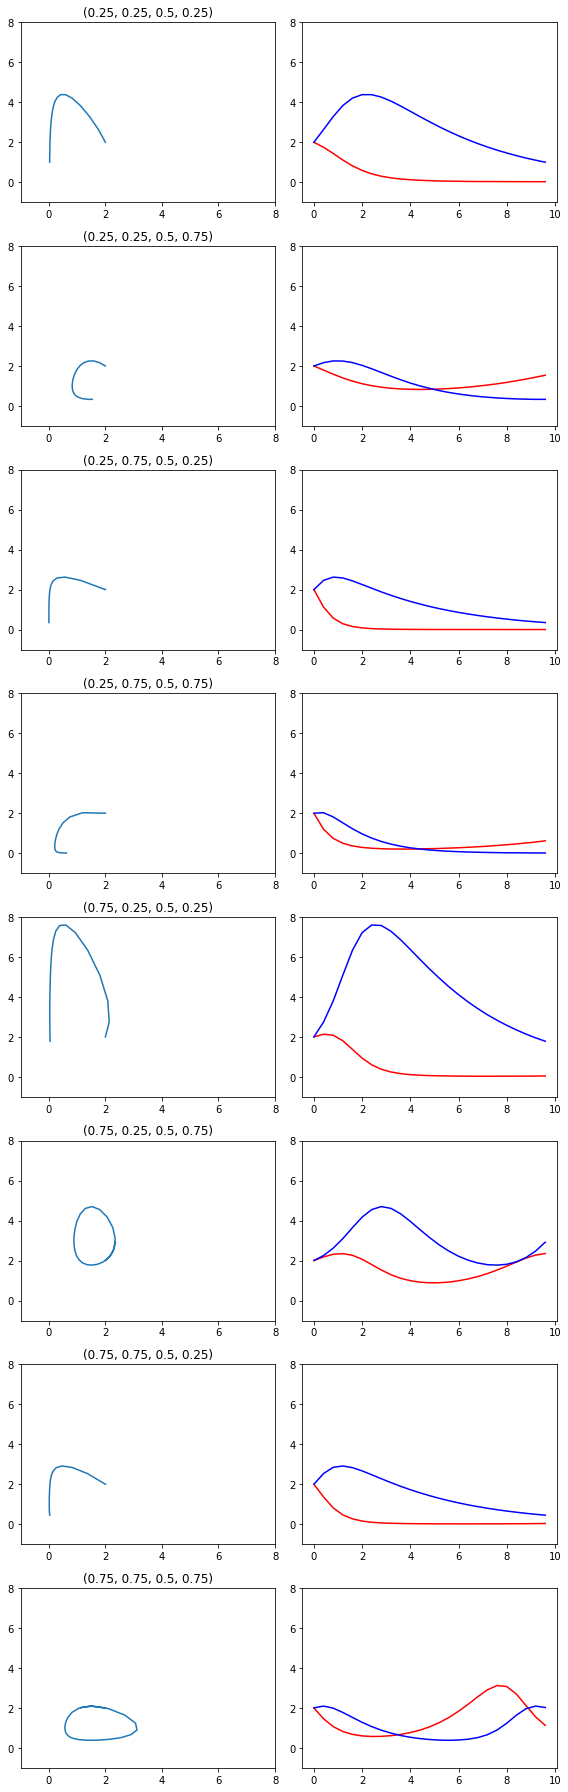

In [10]:
def generate_lv_data(dt=1.0, path="data"):
    os.makedirs(path, exist_ok=True)
    alphas = [0.25, 0.75]
    betas = [0.25, 0.75]
    deltas = [0.5]
    gammas = [0.25, 0.75]

    state0 = [2.0, 2.0]

    modes_list = [(a, b, c, d) for a in alphas for b in betas for c in deltas for d in gammas]

    np.random.seed(1773)
    T = 25
    nof_sequence = 12
    nof_tasks = 4
    mode_per_task = 2
    N = nof_sequence + nof_sequence // 2
    jump = 5

    t = np.arange(0.0, dt * (T + jump) * nof_tasks * N, dt)
    num_mods = len(modes_list)
    mode_datas_train = np.zeros((num_mods, N * (T + jump) * nof_tasks, 2))
    mode_datas_test = np.zeros((num_mods, N * (T + jump) * nof_tasks, 2))

    np.random.seed(1773)
    f, ax = plt.subplots(num_mods, 2, figsize=(8, 25))
    for i, (alpha, beta, delta, gamma) in enumerate(modes_list):
        def f(state, t):
            x, y = state  # Unpack the state vector
            return alpha * x - beta * x * y, delta * x * y - gamma * y  # Derivatives

        states = odeint(f, state0, t)
        states += np.random.normal(0, 0.001, size=states.shape)
        mode_datas_train[i, :] = states
        mode_datas_test[i, :] = odeint(f, state0, t)
        ax[i][0].plot(states[:, 0][:T], states[:, 1][:T])
        ax[i][0].set_ylim(-1, 8)
        ax[i][0].set_xlim(-1, 8)
        ax[i][0].set_title(f"{str((alpha, beta, delta, gamma))}")
        ax[i][1].plot(t[:T], states[:, 0][:T], 'r', t[:T], states[:, 1][:T], 'b')
        ax[i][1].set_ylim(-1, 8)

    plt.tight_layout()
    plt.savefig(f"{path}/Lotka Volterra.png")
    np.random.seed(1773)
    np.random.shuffle(modes_list)
    tasks = [modes_list[i:i + mode_per_task] for i in range(0, len(modes_list), mode_per_task)][:15]
    mode_indexes = np.zeros(num_mods, dtype=int)

    Xs = {"train": [], "test": []}
    Ys = {"train": [], "test": []}
    Modes = {"train": [], "test": []}
    Ns = {"train": nof_sequence, "test": nof_sequence // 2}
    mode_datas = {"train": mode_datas_train, "test": mode_datas_test}

    for key in Xs:
        n = Ns[key]

        for task_id, task in enumerate(tasks):
            for mode_num, mode in enumerate(task):
                for _ in range(n):
                    start_id = mode_indexes[modes_list.index(mode)]
                    end_id = start_id + T
                    data_ = mode_datas[key][modes_list.index(mode)][start_id:end_id]
                    tasks_ = np.ones(1) * task_id
                    modes_ = np.ones(1) * modes_list.index(mode)

                    mode_indexes[modes_list.index(mode)] += T + jump
                    Xs[key].append([data_.copy()])
                    Ys[key].append([tasks_.copy()])
                    Modes[key].append([modes_.copy()])
    
    Xtr = np.concatenate(Xs["train"], axis=0)
    Ytr = np.concatenate(Ys["train"], axis=1)
    Modetr = np.concatenate(Modes["train"], axis=1)

    np.save(f"{path}/training", Xtr)
    np.save(f"{path}/training_tasks", Ytr)
    np.save(f"{path}/training_modes", Modetr)

    Xtest = np.concatenate(Xs["test"], axis=0)
    Ytest = np.concatenate(Ys["test"], axis=1)
    Modetest = np.concatenate(Modes["test"], axis=1)
    np.save(f"{path}/test", Xtest)
    np.save(f"{path}/test_tasks", Ytest)
    np.save(f"{path}/test_modes", Modetest)


generate_lv_data(dt=0.4, path=f"{path}/Lotka Volterra")

# Lorenz Attractor Dataset Generation

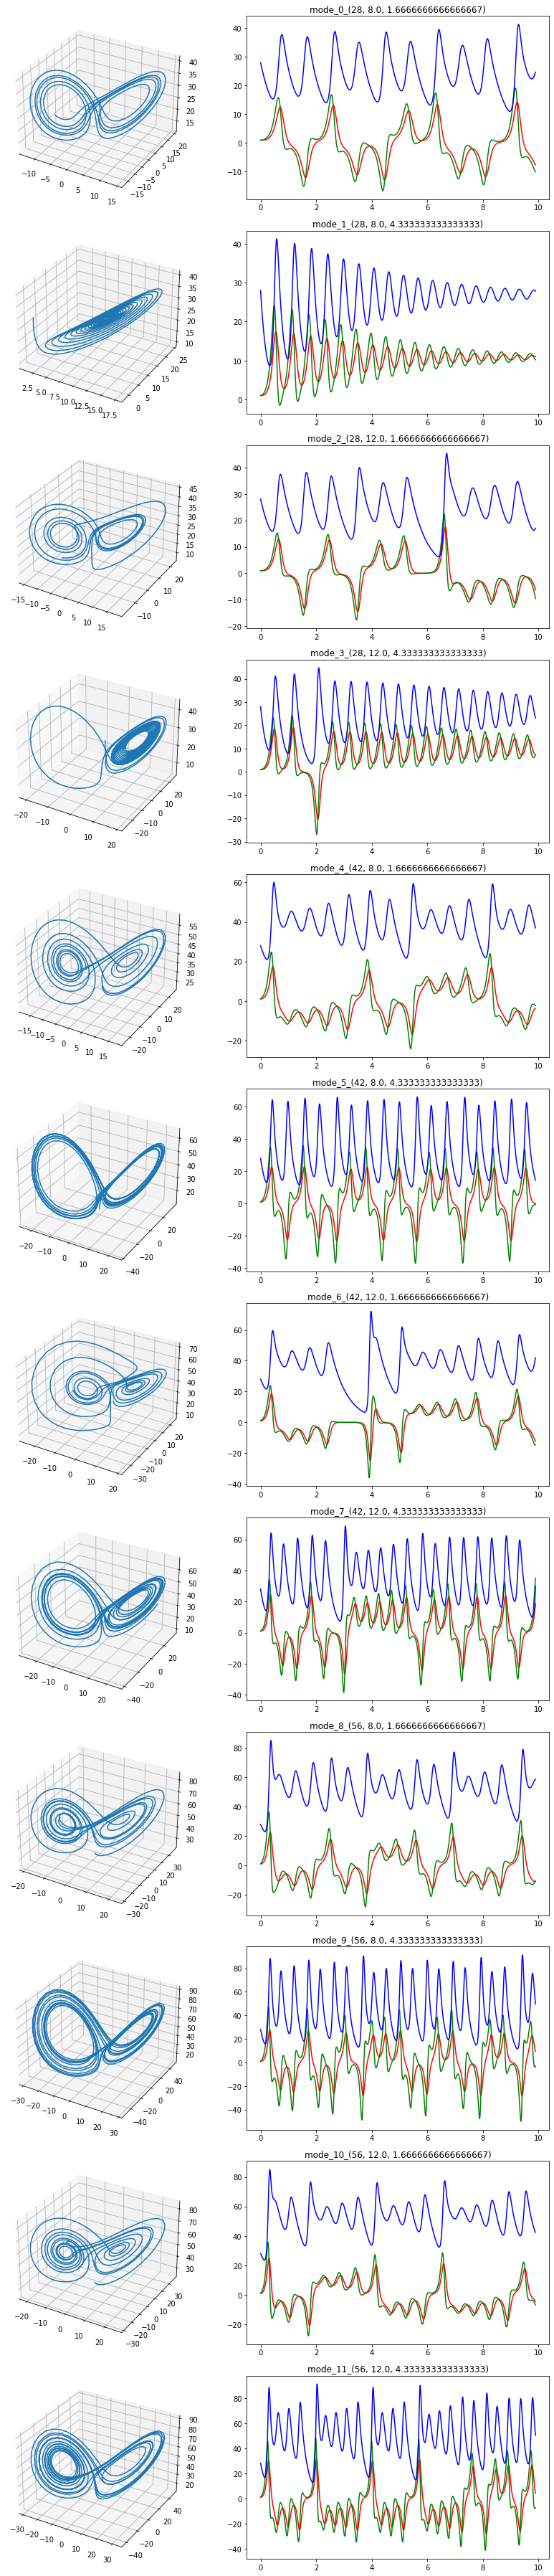

In [13]:

def generate_lorenz_data(dt=0.01, path="data"):
    os.makedirs(path, exist_ok=True)
    rhos = [28, 42, 56]
    sigmas = [8., 12.]
    betas = [5 / 3, 13 / 3]

    state0 = [1.0, 1.0, 28.0]

    modes_list = [(a, b, c) for a in rhos for b in sigmas for c in betas]

    np.random.seed(1773)
    T = 50
    nof_sequence = 12
    nof_tasks = 4
    mode_per_task = 3
    N = nof_sequence + nof_sequence // 2
    jump = 5

    t = np.arange(0.0, dt * (T + jump) * nof_tasks * N, dt)
    num_mods = len(modes_list)
    mode_datas_train = np.zeros((num_mods, N * (T + jump) * nof_tasks, 3))
    mode_datas_test = np.zeros((num_mods, N * (T + jump) * nof_tasks, 3))

    np.random.seed(1773)
    fig = plt.figure(figsize=(12, 50))

    for i, (rho, sigma, beta) in enumerate(modes_list):
        def f(state, t):
            x, y, z = state  # Unpack the state vector
            return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

        states = odeint(f, state0, t)
        states += np.random.normal(0, 0.01, size=states.shape)
        mode_datas_train[i, :] = states
        mode_datas_test[i, :] = odeint(f, state0, t)

        to_plot = 18 * (T + jump)
        ax = fig.add_subplot(num_mods, 2, (2 * i) + 1, projection='3d')
        ax.plot(states[:, 0][:to_plot], states[:, 1][:to_plot], states[:, 2][:to_plot])

        plt.draw()
        ax = fig.add_subplot(num_mods, 2, (2 * i) + 2)
        ax.plot(t[:to_plot], states[:, 0][:to_plot], "r", t[:to_plot], states[:, 1][:to_plot], "g", t[:to_plot],
                states[:, 2][:to_plot], "b")
        

        ax.set_title(f"mode_{i}_{str((rho, sigma, beta))}")

    plt.tight_layout()
    plt.savefig(f"{path}/lorenz_data.png")

    np.random.seed(1773)
    np.random.shuffle(modes_list)
    tasks = [modes_list[i:i + mode_per_task] for i in range(0, len(modes_list), mode_per_task)]
    mode_indexes = np.zeros(num_mods, dtype=int)

    Xs = {"train": [], "test": []}
    Ys = {"train": [], "test": []}
    Modes = {"train": [], "test": []}
    Ns = {"train": nof_sequence, "test": nof_sequence // 2}
    mode_datas = {"train": mode_datas_train, "test": mode_datas_test}

    for key in Xs:
        n = Ns[key]

        for task_id, task in enumerate(tasks):
            for mode_num, mode in enumerate(task):
                for _ in range(n):
                    start_id = mode_indexes[modes_list.index(mode)]
                    end_id = start_id + T
                    data_ = mode_datas[key][modes_list.index(mode)][start_id:end_id]
                    tasks_ = np.ones(1) * task_id
                    modes_ = np.ones(1) * modes_list.index(mode)

                    mode_indexes[modes_list.index(mode)] += T + jump
                    Xs[key].append([data_.copy()])
                    Ys[key].append([tasks_.copy()])
                    Modes[key].append([modes_.copy()])

    Xtr = np.concatenate(Xs["train"], axis=0)
    Ytr = np.concatenate(Ys["train"], axis=1)
    Modetr = np.concatenate(Modes["train"], axis=1)

    np.save(f"{path}/training", Xtr)
    np.save(f"{path}/training_tasks", Ytr)
    np.save(f"{path}/training_modes", Modetr)

    Xtest = np.concatenate(Xs["test"], axis=0)
    Ytest = np.concatenate(Ys["test"], axis=1)
    Modetest = np.concatenate(Modes["test"], axis=1)
    np.save(f"{path}/test", Xtest)
    np.save(f"{path}/test_tasks", Ytest)
    np.save(f"{path}/test_modes", Modetest)


generate_lorenz_data(dt=0.01, path=f"{path}/Lorenz attractor")